## PW on graphcut optimization (binary case)
This session is divided into 3 parts:


* a part on Bayesian classification (see PW1 and PW2)
* a part on object/background segmentation of a colour image with a CRF (conditional random filed)
* a part on the iterative segmentation of a textured image

We will use the PyMaxflow library for the calculation of the graphcut.

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import platform
import tempfile
import os
from scipy import ndimage as ndi
try:
    import maxflow # if not installed, install Maxflow
except:
    !pip install PyMaxflow # For Google Collab
    import maxflow

from skimage import io
from bokeh.plotting import figure, output_file, show
from bokeh.plotting import show as showbokeh
from bokeh.io import output_notebook
output_notebook()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 KB 40.8 MB/s eta 0:00:00


In [ ]:
def affiche_pour_colab(im,MINI=None, MAXI=None,titre=''): #special colab, don't look
  def normalise_image_pour_bokeh(X,MINI,MAXI):
    if MAXI==None:
      MAXI = np.max(X)
    if MINI==None:
      MINI = np.min(X)
    imt=np.copy(X.copy())
    imt=(np.clip(imt,MINI,MAXI)/(MAXI-MINI))
    imt[imt<0]=0
    imt[imt>1]=1
    imt*=255
    sortie=np.empty((*imt.shape,4),dtype=np.uint8)
    for k in range(3):
      sortie[:,:,k]=imt
    sortie[:,:,3]=255
    return sortie

  img = im
  img=normalise_image_pour_bokeh(np.flipud(im),MINI,MAXI)
  p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")], y_range=[im.shape[0], 0], x_range=[0, im.shape[1]], title=titre)
  # p.x_range.range_padding = p.y_range.range_padding = 0
  # must give a vector of images
  p.image(image=[np.flipud(im)], x=0, y=im.shape[0], dw=im.shape[1], dh=im.shape[0], palette="Greys9", level="image")
  p.xgrid.visible = False
  p.ygrid.visible = False
  showbokeh(p)

def affiche(im,MINI=0.0, MAXI=None,titre='',printname=False):
  affiche_pour_colab(im,MINI=MINI, MAXI=MAXI,titre=titre) # under google colab many options disappear

def display_segmentation_borders(image, bin):
    imagergb = np.copy(image)
    from skimage.morphology import binary_dilation, disk
    contour = binary_dilation(bin,disk(15))^bin
    imagergb[contour==1,0] = 255
    imagergb[contour==1,1] = 0
    imagergb[contour==1,2] = 0
    return imagergb

## Binary classification of a noisy image

You have a binary image *IoriginaleBW.png* (binary image of the two classes) and its observed version with a certain distribution of grey levels for each class *Iobservee.png*. The objective is to perform a two-class classification of this observed image (see PW1 and PW2).

### Analysis of the distributions of the 2 classes of the image}


Q1: What are the distributions of the two classes of the image ($P(Y_s|X_s=0)$ (black class) and $P(Y_s|X_s=0)$ (white class))?

Q2: Give the means and variances of the two classes.

*The distributions and the means and variances found in the previous sessions will be used without justification*.

**Your answer &#x270D;**

A1: On considère des distributions gaussiennes de même variance.

A2: **Black class** : $\mu_0 = 96$  
**White class** : $\mu_1 = 164$  
Avec la variance $\sigma = 23$  

## 1.1: Graphcut optimization

Q3: How many nodes does the graph have that is constructed for the search for the minimum capacity cut with only two neighbouring pixels? What do they correspond to? What do the data attachment terms in this graph correspond to and what values do they have for two observed pixels of values $y_s$ and $y_t$? What does the regularisation term correspond to?

**Your answer &#x270D;**

A3: Le graphe a 4 noeuds qui sont la source, le puit, et les deux pixels (noir et blanc). Le terme d'attache aux donnée sera le poids de l'arrête entre le noeuds de chaque pixel et : la source pour une valeur de 0 ; le puit pour ne valeur de 1.  
Le terme de régularisation correspond au poids de l'arrête entre les noeuds des deux pixels.

Q4: Complete the python code cell where it says "#TO BE COMPLETED EX1" with the data attachment and regularization terms as indicated. Run the minimum cut algorithm and view the result.

## 1.2 Searching for the optimal $\beta$.



Q5: By completing the program frame provided below, find the optimal $\beta$ value $\beta_{opt}$ using the "true image" $x$ corresponding to IoriginaleBW.png. You can plot the error values between $x$ and the estimated $\hat{x}$ to find $\beta_{opt}$.



**Your answer &#x270D;**

A5:On trouve $\beta_{opt} = 1770$

Q6: What are the advantages of this optimization approach compared to ICM? Compared to simulated annealing? In theory, do we obtain the same result with both methods (simulated annealing and graphcut)? Under what conditions? What is the advantage of simulated annealing in the general case?

**Your answer &#x270D;**

A6: Cette méthode est plus fiable ue l'ICM et donne forcément le minimum d'énergie. Elle a aussi l'avantage d'être plus rapide que le _simulated annealing_, avec le défaut d'être moins générale, puisqu'elle ne s'adapte qu'au cas de 4-connexité.


Q7: How can you explain that the error rate with the true image can be lower with the simulated annealing result or the ICM than with the graph-cut optimisation?
  

**Your answer &#x270D;**

A7: La méthode graph cut est plus rigoureuse et précise que le _simulated annealing_. On observe tout de même une erreur plus basse avec la deuxième méthode étant donné que le modèle choisi ne représente pas exactement l'image.

Q8: What are the advantages and disadvantages of the Ising model?

**Your answer &#x270D;**

A8: Le modèle d'Ising favorise les contours, au détriment des structures ponctuelles par exemples, qui ont plus de risques d'être effacées.

In [ ]:
# Loading images
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png") # Observed image, noisy
im_orig=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png") # Binary reference image, to assess the quality of the segmentation

affiche(im_obs,titre='Observed image')

In [ ]:
#### to be completed
# TO BE COMPLETED EX1
beta = 1770.0
m0 = 96.0
m1 = 164.0

## binary graph-cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation

# Add the nodes.
# nodeids has the identifiers of the nodes in the grid.
# It creates a set of nodes for all the pixels of the image
nodeids = g.add_grid_nodes(im_obs.shape)

# Add non-terminal edges with the same capacity.
# the edge has the value beta for all adjacent pixels in 4-connexity
g.add_grid_edges(nodeids, beta)

# Add the terminal edges.
# the second argument correspond to the set of edge values to the source
# the third argument correspond to the set of edge values to the sink
g.add_grid_tedges(nodeids, (im_obs-m0)**2, (im_obs-m1)**2)

# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the labels of the nodes in the grid.
# output is 0 if the node is connected to the source, else output is 1
sgm = g.get_grid_segments(nodeids)
im_bin = np.int_(np.logical_not(sgm))

affiche(im_bin,titre = "Result for beta = " + str(beta))
#%%


Max Flow: 76650249.0


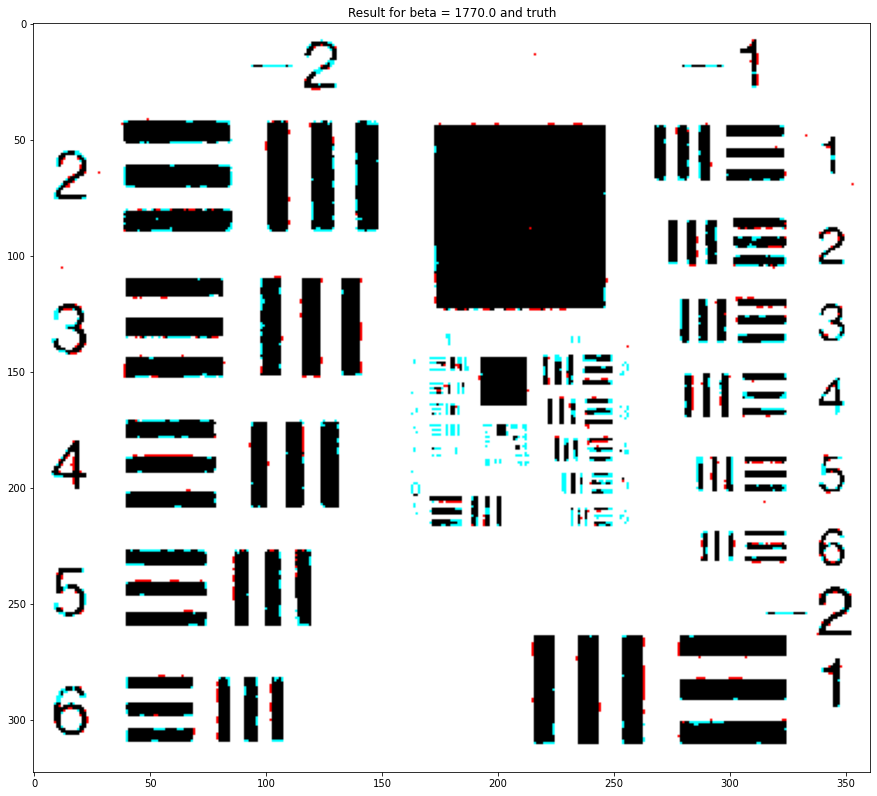

Number of misclassified pixels for beta =  1770.0 :  23886833


In [ ]:
# compute the error image between im_bin and im_orig (the ideal solution) using np.abs and np.sum
error = np.sum(np.abs(im_bin-im_orig))

# visualize the differences between the original image and the solution
plt.figure()
plt.imshow(np.dstack((np.int_(im_orig), im_bin, im_bin))*255)
plt.title("Result for beta = " + str(beta) + " and truth")
plt.show()

print("Number of misclassified pixels for beta = ",beta,": ",int(error))

### Search for the best parameter $\beta$

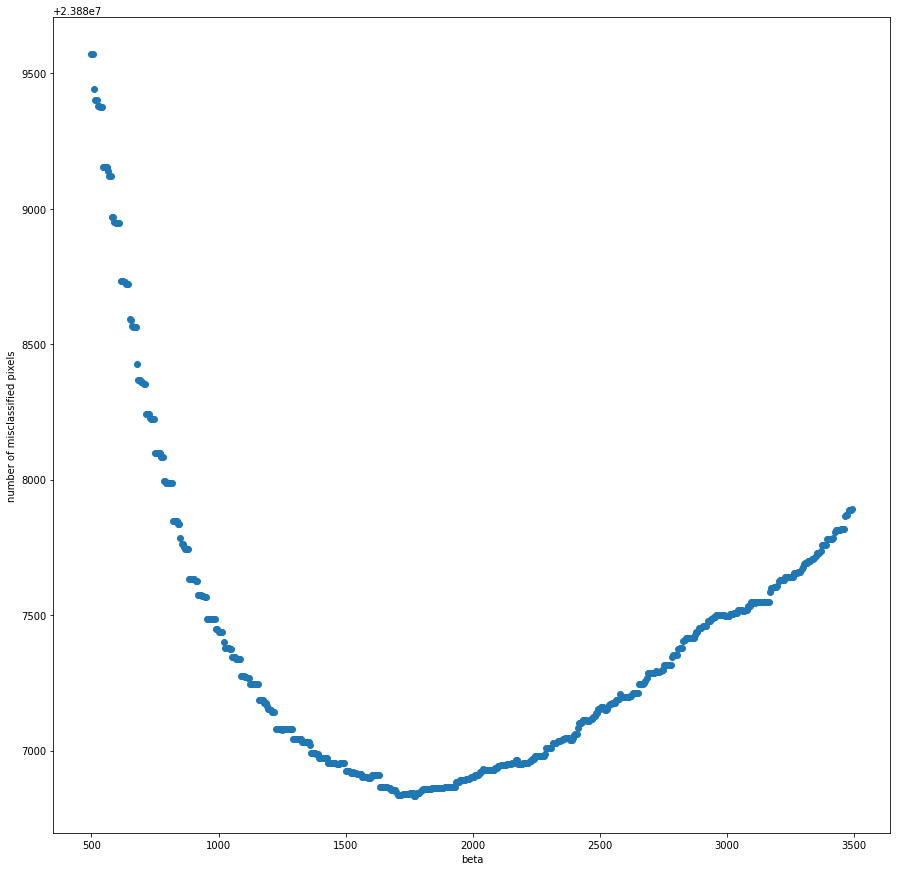

Best beta value:  1770


In [ ]:
im_obs=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/Iobservee.png") # Observed image, noisy
im_orig=io.imread("https://perso.telecom-paristech.fr/tupin/cours/IMA203/TPMARKOV/IoriginaleBW.png") # Binary reference image, to assess the quality of the segmentation

list_beta = []
list_errors = []

# TO BE COMPLETED - choose a range of values and a step to study beta
for beta in range(500,3500,5):
    # TO BE COMPLETED
    m0 = 96.0
    m1 = 164.0

    ## Binary graph cut

    # Create the graph
    g = maxflow.Graph[float]() # graph instantiation

    # Add the nodes. nodeids has the identifiers of the nodes in the grid.
    nodeids = g.add_grid_nodes(im_obs.shape)
    # Add non-terminal edges with the same capacity.
    g.add_grid_edges(nodeids, beta)
    # Add the terminal edges.
    g.add_grid_tedges(nodeids, (im_obs-m0)**2, (im_obs-m1)**2)

    # Find the maximum flow.
    flow = g.maxflow()

    # Get the segments of the nodes in the grid.
    sgm = g.get_grid_segments(nodeids)
    # create the output image
    im_bin = np.int_(np.logical_not(sgm))

    # print("beta = ",beta)
    # compute the error
    error = np.sum(np.abs(im_bin-im_orig))
    list_beta.append(beta)
    list_errors.append(error)

plt.figure()
plt.scatter(list_beta,list_errors)
plt.xlabel("beta")
plt.ylabel("number of misclassified pixels")
plt.show()

best_beta = list_beta[np.argmin(np.array(list_errors))]

print('Best beta value: ', best_beta)

## 2. Classification of a colour image

The objective of this part is to carry out an extension of the method seen previously in the case of the treatment of a colour image *avions.png* in which one wants to separate the objects from the background.

We will first use the same framework (Ising model) as before but with a three-dimensional data attachment (assuming convariance matrices equal to the identity). Then we will introduce a CRF (conditional random field) by weighting the regularisation term of the Ising model by the modulus of the gradient between two pixels of the observed image.  

### 2.1 Binary classification
From the program structure below, carry out the different steps necessary for this classification:
1. Modelling of the background and object distributions (in 3 dimensions this time)
1. Definition of the data attachment term
1. Choice of a value for the regularisation parameter for the Ising model
1. Finding the minimal cut to obtain the object/background classification.

Q9: Comment on these steps and the results obtained.

**Your answer &#x270D;**

A9: Chaque classe est modélisée par une gaussienne dont on détermine la moyenne, en gardant la même variance., et pour chacun des 3 canaux de couleurs.  
Le terme d'attachement aux données est alors une erreur quadratique.  
Ici, on a choisi la valeur $\beta = 10000$.
Pour obtenir l'image binaire (objet-fond), on considère qu'un pixel est  dans la classe de l'avion lorsque tous ses canaux sont correctement classées

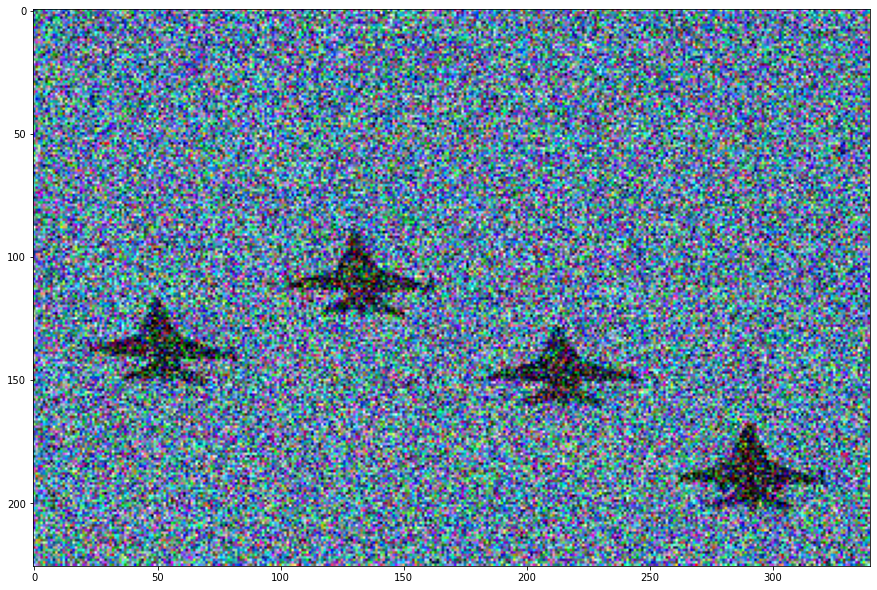

In [ ]:
## Loading and displaying the image
im_obs=io.imread('https://www.dropbox.com/s/ylm0ut8ipu5oonb/avions.png?dl=1')

plt.figure()
#plt.imshow(im_obs,vmin=0,vmax=255)
plt.rcParams['figure.figsize'] = [15, 15]
plt.imshow(im_obs)
plt.show()



#### Determining the parameters of the classes


Plane class: we can use the values of the rectangle [180:200,280:300].

example np.mean(image[180:200,280:300,1]) returns the average of the selected area for channel 1

In [ ]:
# mean of the plane class - 3D vector
m_planes = np.array([np.mean(im_obs[180:200,280:300,0]),np.mean(im_obs[180:200,280:300,1]),np.mean(im_obs[180:200,280:300,2])])

# mean of the sky class
# you can use values in the following square [0:100,150:300]
m_sky =  np.array([np.mean(im_obs[0:100,150:300,0]),np.mean(im_obs[0:100,150:300,1]),np.mean(im_obs[0:100,150:300,2])])

print('For the sky, [R,G,B] = ', m_sky)
print("For the planes, [R,G,B] = ", m_planes)

# check that the obtained values are coherent

For the sky, [R,G,B] =  [ 93.96126667 127.14426667 156.2286    ]
For the planes, [R,G,B] =  [53.645  56.4725 70.2075]


In [ ]:
print( np.sum(np.square(im_obs-m_planes), axis=2).shape)
print(im_obs.shape)

(226, 340)
(226, 340, 3)


In [ ]:
# choose a beta value
beta = 10000

# TO BE COMPLETED
## Binary graph-cut
# use the previous program to create the graph and compute the cut
# be careful of computing the terminal weights using the 3D values
# you can compute 2 distance images with in each pixel the quadratic distance to the mean value
# of each class

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation

# Add the nodes.
# nodeids has the identifiers of the nodes in the grid.
# It creates a set of nodes for all the pixels of the image
nodeids = g.add_grid_nodes(im_obs.shape)

# Add non-terminal edges with the same capacity.
# the edge has the value beta for all adjacent pixels in 4-connexity
g.add_grid_edges(nodeids, beta)

# Add the terminal edges.
# the second argument correspond to the set of edge values to the source
# the third argument correspond to the set of edge values to the sink
g.add_grid_tedges(nodeids, np.sum(np.square(im_obs-m_planes), axis=2).reshape(im_obs.shape[0], im_obs.shape[1],1), np.sum(np.square(im_obs-m_sky), axis=2).reshape(im_obs.shape[0], im_obs.shape[1],1))

# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the labels of the nodes in the grid.
# output is 0 if the node is connected to the source, else output is 1
sgm = g.get_grid_segments(nodeids)
im_bin =np.int_(np.logical_not(np.all(sgm,axis=2)))

affiche(im_bin, titre="Result for beta = " + str(beta));

Max Flow: 3262274565.458847


### 2.2 Use of a CRF (Conditional Random Field) model

We will try here to adapt the model used previously to favour transitions where they are compatible with the gradient. To do this, we will replace the constant $\beta$ for the whole image by a "beta_field" which depends on the norm of the gradient.

Q10: Calculate and display the modulus of the gradient of the aircraft image after it has been grayscaled and convolved by a Gaussian kernel of standard deviation 1. Why use the "boundary='symm'" option when convolving through the Sobel filter? Try it without doing the Gaussian filtering. What is the point?

**Your answer &#x270D;**

A10: L'ajout de _symm_ permet d'éviter les effets de bords.  
Le filtre gaussien filtre l'image, ce qui tend à uniformiser les valeurs, et donc éviter des valeurs de gradient trop importantes, mais facilite aussi la détection des contours.

<ipython-input-70-a500c6c65a77>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
<ipython-input-70-a500c6c65a77>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float)


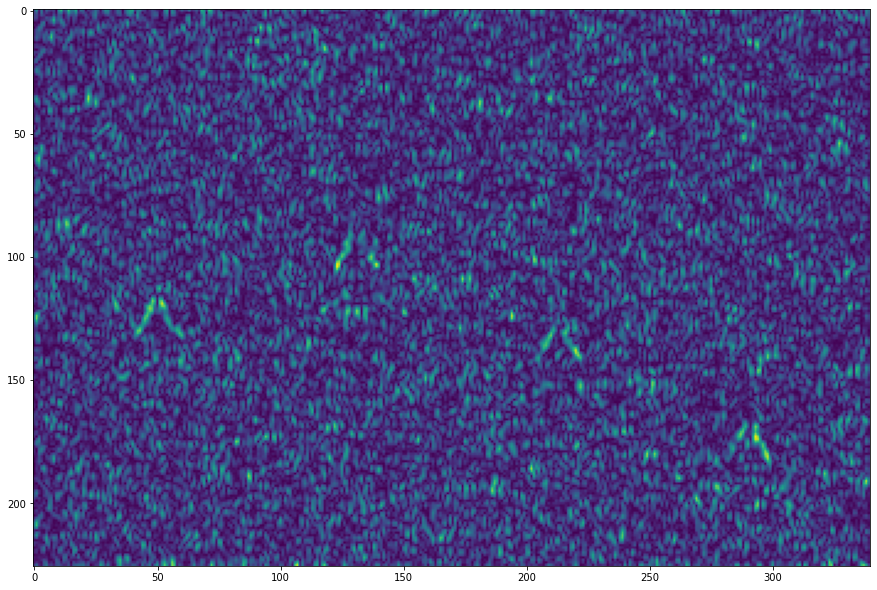

In [ ]:
import scipy.signal as sig
import scipy.ndimage
from skimage import color

def gradient(image):
    """ Array -> tuple[Array*Array]"""
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = np.float)
    # to be completed
    # use mode = 'same' and boundary='symm' in scipy.signal.convolve2d
    derivative_x = sig.convolve2d(image, sobel_x, mode="same", boundary="symm")
    derivative_y = sig.convolve2d(image, sobel_y, mode="same", boundary="symm")
    return([derivative_x,derivative_y])

plane_nb = scipy.ndimage.gaussian_filter(color.rgb2gray(im_obs), 1)
plane_x, plane_y = gradient(plane_nb)
# calculation of the gradient modulus
grad_av = np.sqrt( np.square(plane_x)+ np.square(plane_x) )
plt.figure()
plt.imshow(grad_av)
plt.show()


Complete the code for segmentation by CRF. We will choose $beta\_field=\beta_2\cdot\exp(-grad\_av/h)$ We can use $h=300$ and $\beta_2=20000$. Also replace the constant beta by the field "beta_field" during the "g.add_grid_edges" step.

Q11: Compare the results with and without the contour term.

**Your answer &#x270D;**

A11:

In [ ]:
# calculation of beta_field
# this field will set the value for the 4-neighbours
h = 300
beta2 = 20000
beta_field = beta2 * np.exp(-grad_av/h)
## Binary graph cut
# complete by taking your previous code and replacing
# beta by beta_field in the line g.add_grid_edges

g = maxflow.Graph[float]()
nodeids = g.add_grid_nodes(im_obs.shape)

g.add_grid_edges(nodeids, np.stack([beta_field,beta_field,beta_field],axis=2))
g.add_grid_tedges(nodeids, np.sum(np.square(im_obs-m_planes), axis=2).reshape(im_obs.shape[0], im_obs.shape[1],1), np.sum(np.square(im_obs-m_sky), axis=2).reshape(im_obs.shape[0], im_obs.shape[1],1))
flow = g.maxflow()



# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) # Returns 1 if the pixel is on the drain side after calculating the min cut, 0 if it is on the source side

im_bin =np.int_(np.logical_not(np.all(sgm,axis=2)))

affiche(im_bin, titre="Result for the CRF model")

## 3. Iterative Segmentation with Gaussian Mixture

Q12: Display the "zebra" image below. Is it possible to segment the zebra with the method used to segment the planes?



**Your answer &#x270D;**

A12:

In [ ]:
### Loading a new image
import imageio
I_zebra = imageio.imread('https://upload.wikimedia.org/wikipedia/commons/6/60/Equus_quagga.jpg')
I_zebra = I_zebra[200:,:,:]
rect_zebra = I_zebra[700:1100,1000:2100]
rect_background = I_zebra[:,0:600]
print(I_zebra.dtype)

plt.figure()
plt.imshow(I_zebra)
plt.title('I_zebra')
plt.show()

plt.figure()
plt.imshow(rect_zebra)
plt.title('rect_zebra')
plt.show()

plt.figure()
plt.imshow(rect_background)
plt.title('rect_background')
plt.show()

Q13: Calculate the covariance matrix for the rect_zebra and the rect_background. Display the values and comment on the result. What do the diagonal values correspond to?

**Your answer &#x270D;**

A13:

In [ ]:
print(I_zebra.shape)
V_tulip = np.vstack([I_zebra[:,:,i].flatten() for i in range(3)])
print(I_zebra.shape)

M_cov = np.cov(np.vstack([I_zebra[:,:,i].flatten() for i in range(3)]))
print('Full zebra image')
print(M_cov)

M_cov = np.cov(np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]))
print('Rectangle zebra')
print(M_cov)

M_cov = np.cov(np.vstack([rect_background[:,:,i].flatten() for i in range(3)]))
print('Rectangle background')
print(M_cov)

Q14: Display the histogram for the R, G and B channels for the "rect_zebra" image. Comment on the result.

**Your answer &#x270D;**

A14:

In [ ]:
# allows you to change the display size of plt.show
plt.rcParams['figure.figsize'] = [11, 11]

nomchan = ["red","green", "blue"]
for chan in range(3):
    plt.figure()
    plt.hist(rect_zebra[:,:,chan].flatten(),100)
    plt.title("Histogram of the zebra class for the channel " + nomchan[chan])
    plt.show()


for chan in range(3):
    plt.figure()
    plt.hist(rect_background[:,:,chan].flatten(),100)
    plt.title("Histogram of the background class for the channel " + nomchan[chan])
    plt.show()

Q15: Propose an algorithmic method to identify the two classes of the image "rect_zebra". Use a sklearn implementation of this algorithm to identify the mean vectors ($m_R$,$m_G$,$m_B$) for two classes of the "rect_zebra" image and two classes of the "rect_background" image.

*The following line of code can be used to transform the image into a suitable form.*

X = np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]).transpose()

Comment on the average vectors obtained. They can be displayed as an image using the code provided.

**Your answer &#x270D;**

A15:

In [ ]:
# computation of class parameters in a semi-automatic way
from sklearn.cluster import KMeans
import numpy as np

# use a number of classes =2 for the zebra part (complete n_clusters=?)
X = np.vstack([rect_zebra[:,:,i].flatten() for i in range(3)]).transpose()
kmeans_zebra = KMeans(n_clusters=, random_state=0).fit(X)
mean_vectors_zebra = kmeans_zebra.cluster_centers_

# use a number of classes =2 for the background part
X = np.vstack([rect_background[:,:,i].flatten() for i in range(3)]).transpose()
kmeans_background = KMeans(n_clusters=, random_state=0).fit(X)
mean_vectors_background = kmeans_background.cluster_centers_

In [ ]:
# display of the class centers found as an image
image_mean_vectors = np.zeros((200,200,3),np.uint8)
for i in range(3):
    image_mean_vectors[0:99,0:99,i] = mean_vectors_zebra[0,i]
    image_mean_vectors[0:99,100:199,i] = mean_vectors_zebra[1,i]
    image_mean_vectors[100:199,0:99,i] = mean_vectors_background[0,i]
    image_mean_vectors[100:199,100:199,i] = mean_vectors_background[1,i]

plt.figure()
plt.imshow(image_mean_vectors,vmax = 255)
plt.title("Top: zebra classes, bottom: background classes")
plt.show()

Q16: Display separately two neg-log-likelihood images (the neg-log-likelihood was used as a data attachment in the previous example) for the two zebra classes.
Build a neg-log-likelihood image corresponding to the minimum of the two neg-log-likelihoods of the zebra classes. Similarly for the background class.

Display them and comment.

**Your answer &#x270D;**

A16:

In [ ]:
# calculation of the neg-log-likelihood of the zebra class
neg_log_likelihood_zebra_0 = sum((I_zebra[:,:,i]-mean_vectors_zebra[0,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_0,cmap='gray', vmax = 600)
plt.title("neg_log_likelihood_zebra_0")
plt.show()

neg_log_likelihood_zebra_1 = sum((I_zebra[:,:,i]-mean_vectors_zebra[1,i])**2 for i in range(3))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_1,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_1")
plt.show()

neg_log_likelihood_zebra_combined = np.minimum(sum((I_zebra[:,:,i]-mean_vectors_zebra[0,i])**2 for i in range(3)),sum((I_zebra[:,:,i]-mean_vectors_zebra[1,i])**2 for i in range(3)))

plt.figure()
plt.imshow(neg_log_likelihood_zebra_combined,cmap='gray', vmax = 5000)
plt.title("neg_log_likelihood_zebra_combined")
plt.show()

# TO BE COMPLETED
# calculate the neg-log-likelihood of the background
# call the output neg_log_likelihood_background_combined





Q17: From these combined data attachment images (one for the background and one for the zebra), set up a graph-cut segmentation of the image with the $\beta$ of your choice. Comment the result.

**Your answer &#x270D;**

A17:

In [ ]:
beta =  # Optimal beta value to be determined

## Binary graph cut

# Create the graph.
g = maxflow.Graph[float]() # Graph instantiation
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(I_zebra.shape[0:2]) # Create a grid with a non-terminal node for each pixel in the image
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, beta) # Addition of a beta weight edge between each adjacent node according to the 4-connexity
# Add the terminal edges.

# TO BE COMPLETED
g.add_grid_tedges()


# Find the maximum flow.
flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids)
im_bin = np.int_(np.logical_not(sgm))

plt.figure()
plt.imshow(im_bin)
plt.title("Result of the segmentation")
plt.show()

plt.figure()
plt.imshow(display_segmentation_borders(I_zebra, im_bin))
plt.title("Red segmentation contours")
plt.show()

Q18: From the obtained segmentation, determine the mean vectors for 5 classes for the background and 5 classes for the zebra. Use these lists of mean vectors to construct new neg-log-likelihood combination images. Comment on them.

**Your answer &#x270D;**

A18:

In [ ]:
# The computing of this cell can take several minutes.

X_1 = np.vstack([I_zebra[im_bin==1,i].flatten() for i in range(3)]).transpose()
kmeans_zebra2 = KMeans(n_clusters=5, random_state=0).fit(X_1)
mean_vectors_zebra2 = kmeans_zebra2.cluster_centers_

X_2 = np.vstack([I_zebra[im_bin==0,i].flatten() for i in range(3)]).transpose()
kmeans_background2 = KMeans(n_clusters=5, random_state=0).fit(X_2)
mean_vectors_background2 = kmeans_background2.cluster_centers_

In [ ]:
neg_log_likelihood_zebra_combined_2 = np.amin(np.dstack([(sum((I_zebra[:,:,i]-mean_vectors_zebra2[n_cl,i])**2 for i in range(3))) for n_cl in range(len(mean_vectors_zebra2))]),2)

neg_log_likelihood_background_combined_2 = np.amin(np.dstack([(sum((I_zebra[:,:,i]-mean_vectors_background2[n_cl,i])**2 for i in range(3))) for n_cl in range(len(mean_vectors_background2))]),2)

plt.figure()
plt.imshow(neg_log_likelihood_zebra_combined_2 ,cmap='gray', vmax = 3000)
plt.title("neg_log_likelihood_zebra_combined_2")
plt.show()

plt.figure()
plt.imshow(neg_log_likelihood_background_combined_2,cmap='gray', vmax = 1000)
plt.title("neg_log_likelihood_background_combined_2")
plt.show()


Q19: From these neg-log-likelihood images, segment the image by graph-cut using a new value of $\beta$ that gives you the best result. Comment on the result and the new value of $\beta$ that allowed you to obtain it. What about the new 5-class data attachment compared to the previous one?

**Your answer &#x270D;**

A19:

In [ ]:
beta =  # Optimal beta value to be determined

g = maxflow.Graph[float]() # Graph instantiation
# Add the nodes. nodeids has the identifiers of the nodes in the grid.
nodeids = g.add_grid_nodes(I_zebra.shape[0:2])
# Add non-terminal edges with the same capacity.
g.add_grid_edges(nodeids, beta)
# Add the terminal edges.
g.add_grid_tedges(nodeids,neg_log_likelihood_background_combined_2, neg_log_likelihood_zebra_combined_2)

flow = g.maxflow()

print("Max Flow:", str(flow))
# Get the segments of the nodes in the grid.
sgm = g.get_grid_segments(nodeids) # Returns 1 if the pixel is on the drain side after calculation of the min cut, 0 if it is on the source side
im_bin = np.int_(np.logical_not(sgm))

affiche(im_bin, titre="Result for beta = " + str(beta))

plt.figure()
plt.imshow(im_bin)
plt.show()

plt.figure()
plt.imshow(display_segmentation_borders(I_zebra, im_bin))
plt.title("Red segmentation contours")
plt.show()